## TP 5
### Vision por computadora 1
#### Marcelo Chichiri


- Implementar el detector de fondo Naive usando la mediana como estimador. El algoritmo debe recibir el parámetro N (cantidad de frames utilizados para la estimación) y el intervalo de tiempo para recalcular el fondo.
- Se deben generar las mascaras de foreground y aplicarlas a los frames para segmentar los objetos en movimiento
- Comparar con alguno de los métodos vistos en la practica basados en mezcla de gaussianas

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Carga de librerias
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from time import time
import os
import sys

In [3]:
# Filtro de Naive por Mediana

# Video : es el video obtenido del archivo
# N_frames : cantidad de frames utilizados para la estimación
# frames_idx : indica desde que frame se toma

def FiltroNaive(video='', N_frames=25, frames_idx=0):  
        
    # lee la cantidad de frames en el video
    frames_totales = video.get(cv.CAP_PROP_FRAME_COUNT)
        
    # Se toman aleatoriamente la cantidad de frames indicados en N_frames y lo convierte en entero
    idx_rnd_frames= (frames_totales * np.random.uniform(size=N_frames)).astype(int)

    frames = []
    
    # Agrega cada frame seleccionado a la lista 
    for frame in idx_rnd_frames:
        # Se setea y se lee el frame seleccionado al azar
        video.set(cv.CAP_PROP_POS_FRAMES, frame)
        _, fr = video.read()
      
        # El frame leido se agrega a frames para obtener la media
        frames.append(fr)
        
    # Se establece el video en el mismo frame en el que estaba, para que no se muestren saltos
    video.set(cv.CAP_PROP_POS_FRAMES, frames_idx)
    
    # Calcula la mediana para cada pixel a traves de todos los frames seleccionados
    return np.median(frames, axis=0).astype(np.uint8)     


In [4]:
# Lee el archivo indicado
def lectura_video(filename = ''):
    capture = cv.VideoCapture(filename)
    # Uso la cuenta de frames para ver si el archivo se leyó bien y tiene datos
    if capture.get(cv.CAP_PROP_FRAME_COUNT)==0: 
        print('*** No se pudo abrir el archivo ***')
        sys.exit(0)
    return capture

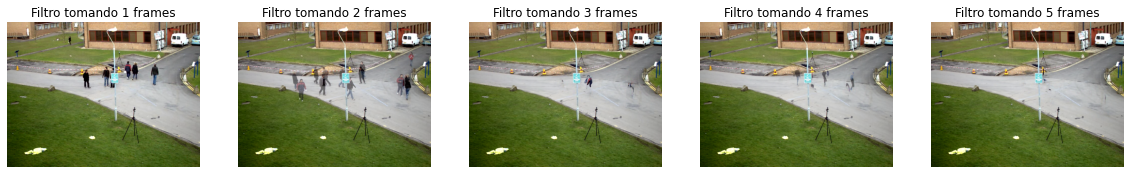

In [5]:
# Prueba tomando distintos frames para calcular el filtro

# Lectura de archivo 
filename = 'vtest.avi' 
capture = lectura_video(filename=filename)

# Se muestran como quedan las imagenes cuando se usan 1, 2, 3... frames para filtrar
plt.figure(figsize=(20, 20))

_, fr = capture.read()
fr = cv.cvtColor(fr, cv.COLOR_BGR2RGB)

for i in range(1, 6):
    filtro_Naive = FiltroNaive(video=capture, N_frames=i, frames_idx=0)
    filtro_Naive = cv.cvtColor(filtro_Naive, cv.COLOR_BGR2RGB)
    plt.subplot(1, 5, i)
    plt.axis('off')
    plt.title(f'Filtro tomando {i} frames')
    plt.imshow(filtro_Naive)


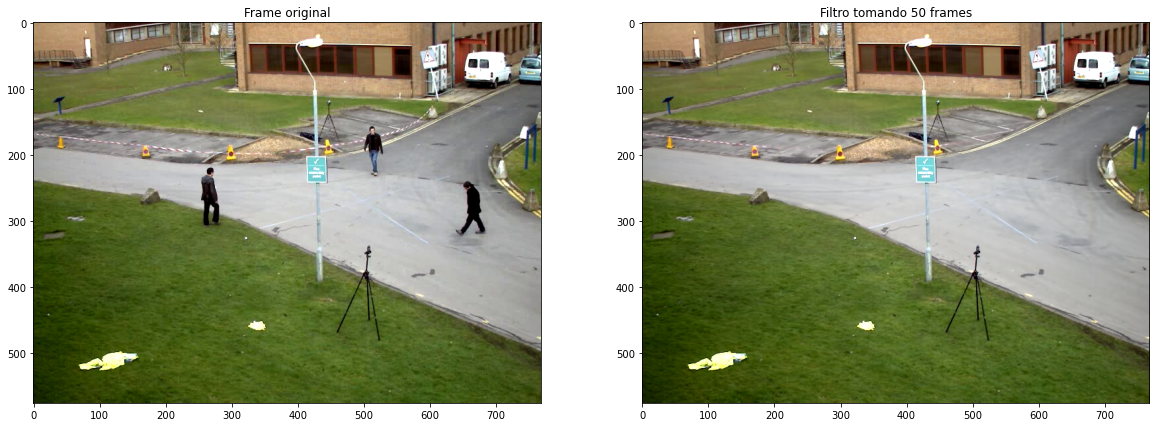

In [6]:
# Comparación de un frame original y filtrado

# Lectura de archivo y verificación
filename = 'vtest.avi'
capture = lectura_video(filename=filename)

N_frames = 50
plt.figure(figsize=(20, 20))

filtro_Naive = FiltroNaive(video=capture, N_frames=N_frames, frames_idx=0)
img_filtrada = cv.cvtColor(filtro_Naive, cv.COLOR_BGR2RGB)

_, fr = capture.read()
fr = cv.cvtColor(fr, cv.COLOR_BGR2RGB)
plt.subplot(1, 2, 1)
plt.title(f'Frame original')
plt.imshow(fr)

plt.subplot(1, 2, 2)
plt.title(f'Filtro tomando {N_frames} frames')
plt.imshow(img_filtrada)  


In [7]:
# Elimina el fondo de un video

# video_fuente : es el video a procesar obtenido con cv.VideoCapture(filename) o similar
# N : es la cantidad de frames utilizados para la estimación por Naive
# periodo_recalculo : es el período de recalculo en segundos  

def background_subtract(video_fuente='', N=10, periodo_recalculo=5):

    # Inicializacion variables para medicion de tiempos
    tiempo_total = 0
    timer0_recalculo = 0
    timer_inicial = 0 
    tiempo_Naive = 0
    tiempo_MOG2 = 0
    tiempo_KNN = 0
    
    # Se crea filtro por método MOG
    backSubMOG2 = cv.createBackgroundSubtractorMOG2()
    
    # Se crea filtro por método KNN
    backSubKNN = cv.createBackgroundSubtractorKNN(detectShadows = True)
    # 
    # Por detector de fondo Naive usando la mediana como estimador
    backSubNaive = FiltroNaive(video=video_fuente, N_frames=N, frames_idx=0)
    
    # Establece el tiempo cero para el calculo de tiempos
    timer0_recalculo = time()
    tiempo_total = time()
    
    while True:
        # Lectura de un frame de video. Lee todos los frames hasta el último
        _, frame = video_fuente.read()
        if frame is None:
            break
        
        # Lee el número de frame actual
        frame_actual = video_fuente.get(cv.CAP_PROP_POS_FRAMES)
        
        # Si se llega al periodo de tiempo indicado en la funcion se recalcula el filtro Naive 
        if (time() - timer0_recalculo) > periodo_recalculo:
            backSubNaive = FiltroNaive(video=video_fuente, N_frames=N, frames_idx=frame_actual)
            timer0_recalculo = time()
        
        # Se aplica filtro Naive y se calcula el tiempo de procesamiento 
        timer_inicial = time()
        filtroNaive = cv.absdiff(frame, backSubNaive)
        filtroNaive_gray = cv.cvtColor(filtroNaive, cv.COLOR_BGR2GRAY)
        _, foregroundNaive = cv.threshold(filtroNaive_gray, 20, 255, cv.THRESH_BINARY)
        tiempo_Naive = tiempo_Naive + (time() - timer_inicial)

        # Se aplica filtro MOG2 y se calcula el tiempo de procesamiento 
        timer_inicial = time()
        filtroMOG2 = backSubMOG2.apply(frame)
        tiempo_MOG2 = tiempo_MOG2 + (time() - timer_inicial)
        
        # Se aplica filtro KNN y se calcula el tiempo de procesamiento 
        timer_inicial = time()        
        filtroKNN = backSubKNN.apply(frame)
        tiempo_KNN = tiempo_KNN + (time() - timer_inicial)   
        
        # Se escribe sobre la imagen original el número de frame procesado
        cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(frame, str(frame_actual), (15, 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))

        # Se escribe sobre la imagen filtrada por Naive el número de frame procesado
        cv.rectangle(foregroundNaive, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(foregroundNaive, str(frame_actual), (15, 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))  

        # Se escribe sobre la imagen filtrada por MOG el número de frame procesado
        cv.rectangle(filtroMOG2, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(filtroMOG2, str(frame_actual), (15, 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
        
        # Se escribe sobre la imagen filtrada por KNN el número de frame procesado
        cv.rectangle(filtroKNN, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(filtroKNN, str(frame_actual), (15, 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
        
        # Visualizacion de los resultados obtenidos  
        
        # Video Original
        cv.namedWindow('Original')
        cv.moveWindow('Original', 0, 0)
        cv.imshow('Original', frame)
        
        # Video filtrado por Naive        
        cv.namedWindow('Filtro Naive')
        cv.moveWindow('Filtro Naive', 0, 0)        
        cv.imshow('Filtro Naive', foregroundNaive)
        
        # Video filtrado por MOG   
        cv.namedWindow('MOG2')
        cv.moveWindow('MOG2', 0,0)
        cv.imshow('MOG2', filtroMOG2)
       
        # Video filtrado por KNN           
        cv.namedWindow('KNN')
        cv.moveWindow('KNN', 0, 0)
        cv.imshow('KNN', filtroKNN)
     
        # Muestra los tiempos de procesamiento de cada método
        print("\r{}".format(f'Timer:{(time()-tiempo_total):.2f} | Tiempo de procesamiento >> Naive: {tiempo_Naive:.3f} seg. | MOG2: {tiempo_MOG2:.3f} seg. | KNN: {tiempo_KNN:.3f} seg.'), end="")
        
        # Se ejecuta el proceso hasta que termine o se pulse "q" o <Esc>
        keyboard = cv.waitKey(10)
        if keyboard == 'q' or keyboard == 27:
            break

    # Al terminar el proceso cierra las ventanas de video 
    cv.destroyAllWindows()
    video_fuente.release()

    # Muestra el promedio de tiempos de procesamiento por cada frame de cada método                            
    print('\n')
    print(f'Tiempo promedio de procesamiento >> Naive: {tiempo_Naive*1000/frame_actual:.3f} mseg./frame | MOG2: {tiempo_MOG2*1000/frame_actual:.3f} mseg./frame | KNN: {tiempo_KNN*1000/frame_actual:.3f} mseg./frame')

In [8]:
## Se prueba el proceso
filename = 'vtest.avi'
video = lectura_video(filename=filename)
background_subtract(video_fuente=video, N=20, periodo_recalculo=2) 

Timer:42.28 | Tiempo de procesamiento >> Naive: 0.711 seg. | MOG2: 2.895 seg. | KNN: 3.144 seg.

Tiempo promedio de procesamiento >> Naive: 0.895 mseg./frame | MOG2: 3.642 mseg./frame | KNN: 3.954 mseg./frame


#### Resultados y conclusiones

Se implementó la función para la segmentación de fondo/primer plano por el algoritmo de Naive utilizando la mediana como estimador. Este algoritmo consiste en elegir N frames en forma aleatoria y calcular la mediana entre ellos (el background), luego se resta el frame actual con el valor calculado y se binariza para obtener la mascara, es decir el foreground. Cada cierto intervalo de tiempo se actualiza el modelo del background recalculando la mediana. \
Se pudo comprobar que el proceso funcionó correctamente. 

Se compararon los métodos de Naive (por mediana) con el método MOG2 (cv.createBackgroundSubtractorMOG2 de OpenCV), basado en mezcla de gaussiana, y con el método KNN (cv.createBackgroundSubtractorKNN de OpenCV), basada en el método K-vecinos cercanos. \
Se midieron los tiempos utilizados en cada uno de los métodos y se puedo comprobar que Naive se resuelve en, aproximadamente, 25% del tiempo que utiliza MOG2 y KNN (sin considerar el tiempo que emplea para hacer el recalculo del filtro).
